# Приоритизация гипотез, анализ результатов A/B теста для интернет-магазина


1. Контекст задачи: нам выданы три файла с данными: о гипотезах и их параметрами, о покупках и количестве просмотров
2. Цель проекта: выяснить какие гипотезы выше по приоритету, разобрать каково влияние рассматриваемого предложения на выручку, так же рассмотрим результаты A/B теста и сравним результаты двух групп с помощью таких метрик, как: куммулятивная выручка, куммулятивный средний чек, относительное изменение кумулятивного среднего чека, кумулятивное среднее количество заказов на посетителя, относительное изменение кумулятивного среднего количества заказов на посетителя, статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным, статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным, статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным, статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.
3. Наши задачи:
  * найти для каждой гипотезы значение ICE и RICE
  * выяснить какие гипотезы приоритетнее
  * разобрать результаты A/B теста
  * выявить, как рассматриваемая гипотеза повлияла на поведение клиентов
  * понять какая судьба у рассматриваемой гипотезы
4. Описание данных:
* структура hypothesis.csv:
  * Hypothesis - наименования гипотезы
  * Reach - оценка охвата аудитории
  * Impact - оченка влияния гипотезы
  * Confidence - оценка уверенности в гипотезе
  * Efforts - оценка усилий для гипотезы

* структура orders.csv:
  * transactionId - идентификатор заказа
  * visitorId - идентификатор покупателя
  * date - дата покупки
  * revenue - стоимость заказа
  * group - группа тестирования

* структура visitors.csv:
  * date - дата визита
  * group - группа тестирования
  * visitors - количество посетителей

# Часть 1

## Подготовка данных к анализу

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as st

In [10]:
option1 = '/datasets/orders.csv'
option2 = 'hypothesis.csv'

if os.path.exists(option1):
  hypothesis = pd.read_csv(option1)
else:
  hypothesis = pd.read_csv(option2)

In [12]:
pd.set_option('display.max_colwidth', None)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Загрузили данные. Видим, что с ними все в порядке, но на всякий случай проверим это кодом.

In [16]:
display(hypothesis.duplicated().sum())
display(hypothesis.isna().any().any())

0

False

Пропусков и дубликатов в датафрейме нет

---



Преобразуем названия столбцов, чтобы дальше было легче с ними работать

In [20]:
hypothesis.columns = hypothesis.columns.str.lower()

## Посчитаем ICE для гипотез


In [23]:
hypothesis['ICE'] = hypothesis['confidence'] * hypothesis['impact'] / hypothesis['efforts']
hypothesis['ICE'] = hypothesis['ICE'].apply(lambda x: '{0:.2f}'.format(x)).astype('float')
hypothesis.sort_values(by = 'ICE', ascending = False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


Заметили лидирующие гипотезы. Гипотеза - Запустить акцию, дающую скидку на товар в день рождения - с показателем ICE = 16.2, гипотеза - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей - с ICE = 13.3, гипотеза - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок - с ICE = 11.2. Остальные гипотезы имеют меньше 10 в данном показателе. Самой не приоритетной гипотезой оказалась: Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей, с показателем ICE = 1.



---



## Посчитаем RICE для гипотез

In [31]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values(by = 'RICE', ascending = False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


На первом месте с отрывом теперь оказалась гипотеза - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок - с показателем RICE = 112, далее - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа - с RICE = 56, на третьем месте гипотеза - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	- с RICE = 40.  На последнем же месте гипотеза - Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей - с RICE = 3.



---



## Разница между показателями ICE и RICE

In [38]:
display(hypothesis.sort_values(by = 'ICE', ascending = False).index)
display(hypothesis.sort_values(by = 'RICE', ascending = False).index)

Index([8, 0, 7, 6, 2, 1, 5, 3, 4], dtype='int64')

Index([7, 2, 0, 6, 8, 3, 1, 5, 4], dtype='int64')

Как мы видим, приоритизация значительно изменилась при смене фреймворка. Восьмая гипотеза стала первой вместо третьей, девятая гипотеза спустилась до пятого места вместо первого, также третья гипотеза поднялась до второго места, а первая гипотеза опустилась только на одно место.

Так произошло, потому что при использовании фреймворка ICE мы пренебрегаем охватом аудитории, то есть сколько пользователей затронет какое-либо предложение. А при использовании RICE мы учитываем это, поэтому у нас получился сильно другой результат.



---

# Часть 2

In [42]:
import datetime as dt

a1 = 'orders.csv'
a2 = '/datasets/orders.csv'

b1 = 'visitors.csv'
b2 = '/datasets/visitors.csv'

if os.path.exists(a1):
  orders = pd.read_csv(a1)
else:
  orders = pd.read_csv(a2)

if os.path.exists(b1):
  visitors = pd.read_csv(b1)
else:
  visitors = pd.read_csv(b2)

orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [43]:
display(orders.head())
display(visitors.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [44]:
display(orders.isna().any().any())
display(orders.duplicated().sum())
display(visitors.isna().any().any())
display(visitors.duplicated().sum())

False

0

False

0

Загрузили данные. Поменяли на необходимый тип данные о дате, проверили на пропуски и дубликаты - их не оказалось.



---



## Подготовка данных

Для того, чтобы сравнивать значения из выборок, создадим все необходимые переменные с нужными для нас данными.

In [50]:
visitorsADaily = visitors.query('group == "A"')[['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date': 'max', 'visitorsPerDateA': 'sum'}), axis = 1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors.query('group == "B"')[['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date': 'max', 'visitorsPerDateB':'sum'}), axis = 1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


ordersADaily = orders.query('group == "A"').groupby('date', as_index = False)[['date', 'transactionId', 'revenue']].agg({'date':'max', 'transactionId':'nunique', 'revenue':'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg({'date':'max', 'ordersPerDateA':'sum', 'revenuePerDateA':'sum'}), axis = 1).sort_values(by = 'date')
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders.query('group == "B"').groupby('date', as_index = False)[['date', 'transactionId', 'revenue']].agg({'date':'max', 'transactionId':'nunique', 'revenue':'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg({'date':'max', 'ordersPerDateB':'sum', 'revenuePerDateB':'sum'}), axis = 1).sort_values(by = 'date')
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

data = (
    ordersADaily.merge(
        ordersBDaily, on='date', how='left'
    )
    .merge(ordersACummulative, on='date', how='left')
    .merge(ordersBCummulative, on='date', how='left')
    .merge(visitorsADaily, on='date', how='left')
    .merge(visitorsBDaily, on='date', how='left')
    .merge(visitorsACummulative, on='date', how='left')
    .merge(visitorsBCummulative, on='date', how='left')
)
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Данные готовы, можно приступать к сравнению групп



---



### График куммулятивной выручки по группам

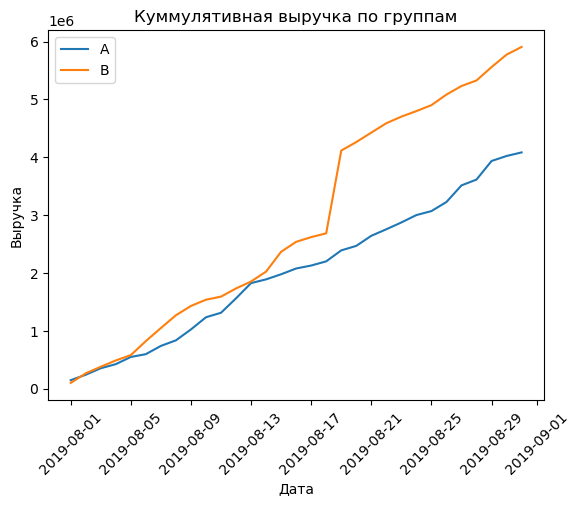

In [54]:
plt.plot(data['date'], data['revenueCummulativeA'], label = 'A')
plt.plot(data['date'], data['revenueCummulativeB'], label = 'B')
plt.title('Куммулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

Видим, что до 13 августа выручка не так сильно разнится. Но после 17 августа происходит резкий подъем. Возможно, есть выбросы



---



### График куммулятивного среднего чека по группам

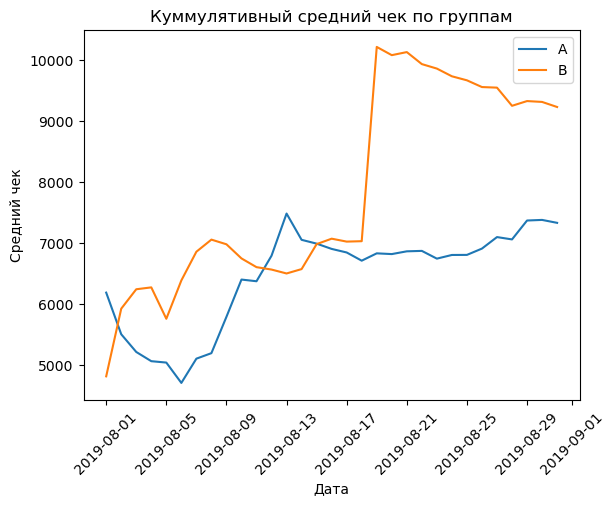

In [59]:
plt.plot(data['date'], data['revenueCummulativeA'] / data['ordersCummulativeA'], label = 'A')
plt.plot(data['date'], data['revenueCummulativeB'] / data['ordersCummulativeB'], label = 'B')
plt.title('Куммулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

Со средим чеком ситуация похожая, до 17 августа происходят росты и убывания у обеих групп, непонятно какая лидирует. После 17 августа резкий подъем группы B. Линия прямая, можно сделать вывод, что выбросы все-таки есть



---



### График относительного изменения куммулятивного среднего чека группы B к группе A

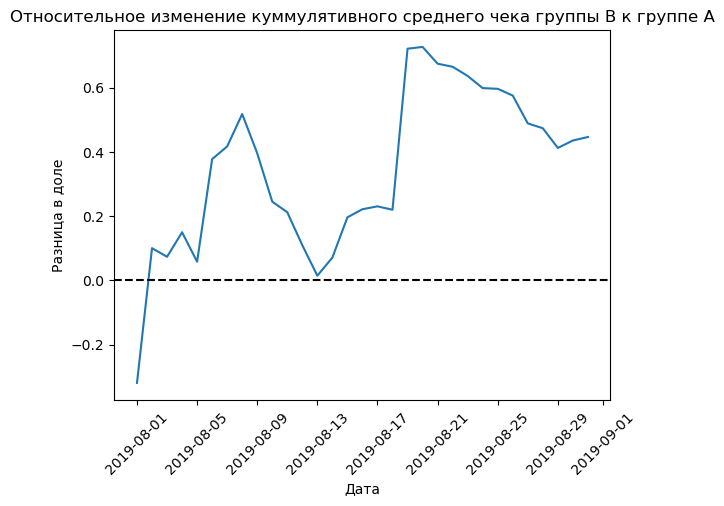

In [64]:
plt.plot(data['date'], (data['revenueCummulativeB'] / data['ordersCummulativeB']) / (data['revenueCummulativeA'] / data['ordersCummulativeB']) - 1)
plt.title('Относительное изменение куммулятивного среднего чека группы B к группе А')
plt.xlabel('Дата')
plt.ylabel('Разница в доле')
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.xticks(rotation = 45)
plt.show()

По этому графику мы можем понять, что данные не стабильны. Видна положительная разница для групппы В, но так же видны и аномальные значения.



---



### График куммулятивного среднего количества заказов на посетителя по группам

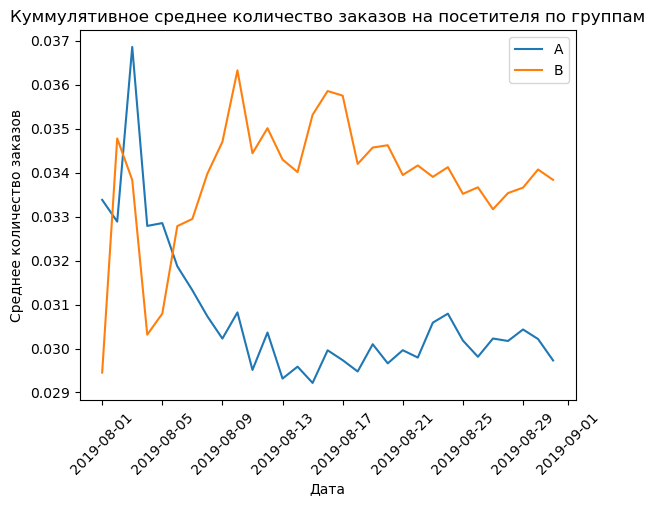

In [69]:
plt.plot(data['date'], data['ordersCummulativeA'] / data['visitorsCummulativeA'], label = 'A')
plt.plot(data['date'], data['ordersCummulativeB'] / data['visitorsCummulativeB'], label = 'B')
plt.title('Куммулятивное среднее количество заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

Спустя неделю данные приняли стабильное отношение, которое продолжается в дальнейшем. Среднее количество заказов группы В явно больше группы А.



---



### График относительного изменения среднего количества заказов на посетителя группы B к группе А

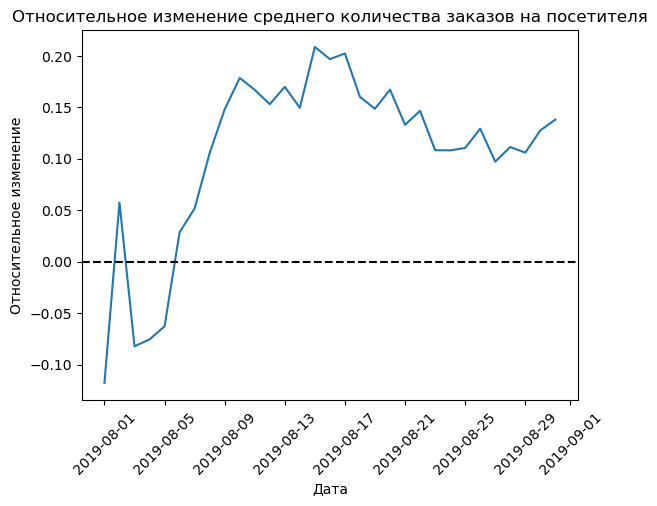

In [74]:
plt.plot(data['date'], (data['ordersCummulativeB'] / data['visitorsCummulativeB']) / (data['ordersCummulativeA'] / data['visitorsCummulativeA']) - 1)
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.title('Относительное изменение среднего количества заказов на посетителя')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.xticks(rotation = 45)
plt.show()

Изначально изменение было "скачущим" и больше отрицательным, но спустя время относительное изменение так же показывает, что группа В в этом параметре выше группы А



---



### Точечный график количества заказов по пользователяи

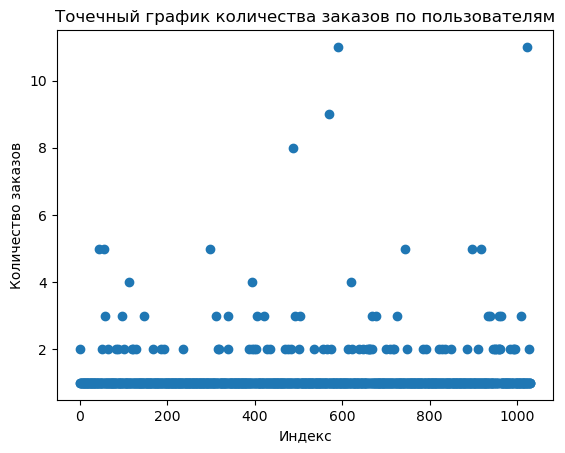

In [79]:
quantity_orders = orders.groupby('visitorId', as_index = False).agg({'transactionId':'nunique'})
quantity_orders.columns = ['userId', 'orders']

plt.scatter(quantity_orders.index, quantity_orders['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Индекс')
plt.ylabel('Количество заказов')
plt.show()

Видим, что между 2 и 4 редкие значения. Значения после 4 наверняка являются выбросами. Слишком уж редкие значения



---



### Подсчет 95 и 99 перцентилей для количества заказов на пользователя

In [84]:
np.percentile(quantity_orders['orders'], [95, 99])

array([2., 4.])

Как и предполагалось, 5 процентов от всех значений больше 2. 1% уже больше 4. Возьмем значения, меньшие 3. Так мы уберем от 1 до 5% значений.



---



### Точечный график стоимости заказов

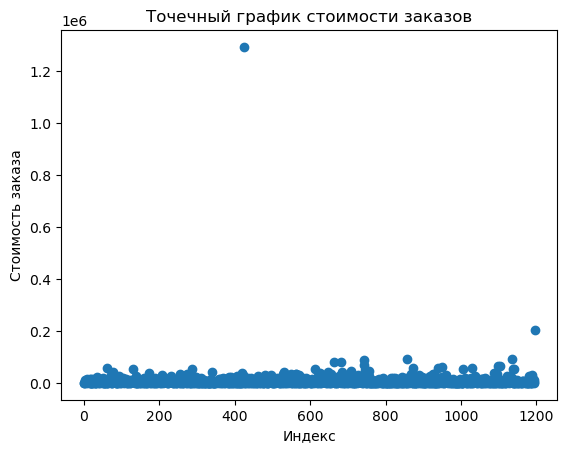

In [89]:
plt.scatter(orders.index, orders['revenue'])
plt.title('Точечный график стоимости заказов')
plt.xlabel('Индекс')
plt.ylabel('Стоимость заказа')
plt.show()

Здесь выбросов не так много, есть 2 значения выбивающихся из общей кучи.



---



### Подсчет 95 и 99 перцентилей стоимости заказов

In [94]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

5% значений это те, что больше 28000. 1% - больше 58233. Возьмем значения, меньшие 30000. Так мы уберем 1-5% от значений.



---



### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

In [99]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [100]:
ordersByUsersA = orders.query('group == "A"').groupby('visitorId', as_index = False).agg({'transactionId':'nunique'})
ordersByUsersA.columns = ['userId', 'orders']
ordersByUsersA.head()

,userId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


In [101]:
ordersByUsersB = orders.query('group == "B"').groupby('visitorId', as_index = False).agg({'transactionId':'nunique'})
ordersByUsersB.columns = ['userId', 'orders']
ordersByUsersB.head()

,userId,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


In [102]:
sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, index = np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name = 'orders')], axis = 0)
sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0, index = np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name = 'orders')], axis = 0)
display(sampleA.head())
display(sampleB.head())

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

Нулевая гипотеза: средние количества заказов по группам равны

Альтернативаня гипотеза: средние количества заказаов по группа не равны

In [105]:
a = 0.05
pvalue = '{0:.3f}'.format(st.mannwhitneyu(sampleA, sampleB).pvalue)
display('pvalue:' ,pvalue)
if float(pvalue) > a:
  display('Не отвергаем нулевую гипотезу')
else:
  display('Отверагем нулевую гипотезу в пользу альтернативной')

display('Разница между средними:' ,'{0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

'pvalue:'

'0.017'

'Отверагем нулевую гипотезу в пользу альтернативной'

'Разница между средними:'

'0.138'

pvalue составил всгео 0.017. Мы отвергаем нулевую гипотезу в пользу альтернативной. Разница составила 13.8%. Можно сделать предположение, что нововведение затронуло то, как часто пользователи делают покупки. Если после "очистки" данных результат будет тем же, то данная гипотеза имеет большую вероятность успеха



---



### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

In [112]:
pvalue = '{0:.3f}'.format(st.mannwhitneyu(orders.query('group == "A"')['revenue'], orders.query('group == "B"')['revenue']).pvalue)
a = 0.05
display('pvalue:' ,pvalue)
if float(pvalue) > 0.05:
  display('Не отвергаем нулевую гипотезу')
else:
  display('Отверагем нулевую гипотезу в пользу альтернативной')
display('Разница между средними:' ,'{0:.3f}'.format(orders.query('group == "B"')['revenue'].mean() / orders.query('group == "A"')['revenue'].mean() - 1))

'pvalue:'

'0.729'

'Не отвергаем нулевую гипотезу'

'Разница между средними:'

'0.259'

Разница в среднем чеке оказалась несущественной. Pvalue равен 0.729, что намного больше уровня значимости, хотя разница и составила 25.9%. Видимо, гипотеза была направлена именно на увеличение количества заказов



---



### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [117]:
usersWithManyOrders = pd.concat([ordersByUsersA.query('orders > 3')['userId'], ordersByUsersB.query('orders > 3')['userId']], axis = 0)

usersWithExpensiveOrders = orders.query('revenue > 30000')['visitorId']
usersWithExpensiveOrders.columns = ['userId']

abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates()
display(abnormalUsers.head())
display(len(abnormalUsers))

18      199603092
23      237748145
227    2038680547
269    2378935119
278    2458001652
dtype: int64

57

Сделали список пользователей, которые делают аномальные количество покупок и стоимость заказа. Он нам понадобится для очистки данных от аномалий

In [119]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], pd.Series(0, index = np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name = 'orders')], axis = 0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], pd.Series(0, index = np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name = 'orders')], axis = 0)

display(sampleAFiltered.head())
display(sampleBFiltered.head())

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

Нулевая гипотеза: разницы между средним количеством покупок на посетителя по группам нет

Альтернативная гипотеза: средние количества покупок на посетителя по группа отличаются

In [121]:
pvalue ='{0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered).pvalue)
a = 0.05
display(pvalue)
if float(pvalue) > a:
  display('Не отвергаем нулевую гипотезу')
else:
  display('Отвергаем нулевую гипотезу')
display('{0:.3f}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

'0.018'

'Отвергаем нулевую гипотезу'

'0.148'

Даже после очистки данных, pvalue оказался равен 0.018, что меньше уровня значимости. Следовательно, отвергаем нулевую гипотезу в пользу альтернативной. Все-таки теперь можно с уверенностью сказать, что проверяемая гипотеза повлияла на среднее количество заказов в положительную сторону.



---



### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [126]:
pvalue = '{0:.3f}'.format(st.mannwhitneyu(orders[np.logical_not(orders['visitorId'].isin(abnormalUsers))].query('group == "A"')['revenue'], orders[np.logical_not(orders['visitorId'].isin(abnormalUsers))].query('group == "B"')['revenue']).pvalue)
a = 0.05
display(pvalue)
if float(pvalue) > a:
  display('Не отвергаем нулевую гипотезу')
else:
  display('Отвергаем нулевую гипотезу в пользу альтернативной')

display('{0:.3f}'.format(orders[np.logical_not(orders['visitorId'].isin(abnormalUsers))].query('group == "B"')['revenue'].mean() / orders[np.logical_not(orders['visitorId'].isin(abnormalUsers))].query('group == "A"')['revenue'].mean() - 1))

'0.958'

'Не отвергаем нулевую гипотезу'

'-0.020'

После очистки данных, результат pvalue только увеличился, что означает, что мы не можем отвергнуть нулевую гипотезу. Видимо, гипотеза не эффективна для увеличения среднего чека



---



### Решение по результатам теста

Результаты теста проанализированы. Пришли к выводу, что можно остановить тест, зафиксировать победу одной из групп.
Поскольку результаты показали нам разницу в количестве заказов по пользователям, выявили разницу в 14.8% в пользу группы B, проверили гипотезу о статистической значимости различия в среднем количестве заказов по группам с "очищенными" и "сырыми" данными. Результат и там, и там оказались похожими: отвергли нулевую гипотезу о равности в пользу альтернативной, среднее количество заказов у группы B оказалось больше.
Проверили так же и средний чек, но там результат оказался другим и в "сырых" данных, и в "очищенных" данных. Значимых различий не обнаружено, нулевую гипотезу о равности не получилось отвергнуть.



---



# Вывод

Нам был дан кейс, и мы провели предобработку данных, приоритизировали гипотезы, рассмотрели результаты A/B теста, сравнили группы тестирования, определили дальнейшую судьбу данного теста и гипотезы. В ходе предобработки данных не было замечено ни пропусков, ни дубликатов ни в каком файле csv. Единственное, что поменяли - это типы данных для столбцов с датой. Далее мы рассчитали для 9 гипотез значения ICE и RICE. Результаты, которые мы получили - оказались разными. Все дело в отличии между данными метриками: в RICE мы рассматриваем оценку охвата, а в ICE - нет. При оценке ICE мы получили такие результаты: 1 место - "Запустить акцию, дающую скидку на товар в день рождения", 2 место - "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей", 3 место - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". При RICE: 1 место - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", 2 место - "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа", 3 место - "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей". Далее мы рассматривали результаты A/B теста. Куммулятивная выручка и куммулятивный средний чек показали похожий результат: до 17 августа значения двух групп несильно различались, но после этой даты произошел резкий рост, из-за которого группа B показала хорошие результаты. Подозревалось, что во виноваты выбросы. График относительного изменения среднего чека между группами показал такой же результат: после 17 августа резкий подъем. А вот среднее количество заказов и на графике и в относительном изменении показал хорошие результаты в пользу группы B. Далее мы начали рассматривать выбросы в данных, а именно точечные графики, и высчитывать перцентили. Выяснили, что 5% пользователей делают больше 2 заказов, а также 5% пользователей делают заказ дороже 28000. 1% пользователей делают более 4 заказов, также 1% пользователей делают покупки стоимостью свыше 58233. Было принято решение избавиться от некоторых данных, а именно от пользователей которые делают более трех заказов, а также от тех, кто делают покупки дороже 30000. Так как их посчитали пользователями с аномальными покупками, которые искажают результаты теста. Перед тем как "очищать" данные, мы рассчитали статистическую значимость различия в среднем чеке между группами. Не было достаточных оснований, чтобы отвергать гипотезу о равности между рассматриваемыми данными, хоть разница и была 25.9%. Так же подсчитали статистическую значимость различия в среднем количестве заказов на посетителя по группам. Есть достаточно оснований отвергнуть нулевую гипотезу о равности между рассматриваемыми данными в пользу альтернативной, которая говорит об обратном. После очистки данных мы рассмотрели те же метрики. Различий практически не было. Средний чек группы В после очистки стал только хуже, видимо, на графике поспособствовали именно они. А среднее количество заказов на пользователя по группам так же лучше со стороны группы В на 15%.

Проведя весь анализ, можно сказать, что, скорее всего, тест удался, и его можно завершать в пользу группы B. Поскольку изначальная цель - рассмотреть влияние нововведения на выручку. А мы выяснили, что средний чек хоть и не вырок, но на 15% увеличось количество заказов, что может положительно повлиять на выручку компании.